# Find Stamps with Single Antenna High Power Signals

Noah Stiegler

7/9/2024

Some of the hits with stamp files are due to a single antenna recording a very strong signal which looks like a technosignature. However, because all the antennas are pointed in the same direction on the sky, this means the signal isn't from an extraterrestrial technosignature, but rather RFI (radio frequency interference) from near the antenna itself. In this notebook, I'm going to explore different ways of finding these anomalous signals so we can weed them out of the dataset

### Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Import regular packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import pickle

In [3]:
# Next we'll import the seticore viewer package: 
# Unfortunately, it can be a little fiddley
# I'm using the Python 3.7 (base) conda environment on blpc1 
# I was having issues with the Python 3.9 seticore_viewer conda environment I created on blpc1
# The standard maintained branch is https://github.com/MydonSolutions/seticore
# although I added some additional functionality on my own fork at https://github.com/NMStiegler/seticore
# so if my plots look different that's why
# These packages may need to be pip installed if they're not already
try:
    from seticore import viewer
except:
    # May need to install pycapnp
    try:
        %pip install pycapnp
    except:
        %conda install pycapnp
    # %pip install "git+https://github.com/NMStiegler/seticore#egg=seticore&subdirectory=python"
    %pip install pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
    from seticore import viewer

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


In [4]:
# Define where the data is

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    DATA_PATH = "/datax/scratch/nstieg/"
    # Define which data you want to look at
    BFR_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.bfr5"
    STAMPS_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps"
elif hostname == "cosmic-gpu-1":
    DATA_PATH = "/mnt/cosmic-storage-2/data1/vla_target/23A-362.sb43789194.eb44583327.60212.544836180554/23A-362.sb43789194.eb44583327.60212.544836180554.9.1/"
    BFR_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.bfr5"
    STAMPS_PATH = DATA_PATH + "23A-362.sb43789194.eb44583327.60212.544836180554.9.1.AC.C704.0000.raw.seticore.0000.stamps"
else:
    raise Exception("Data path not known")

In [5]:
# Load in the stamps (with recipes in bfr5 file with the same name in the same location)
# and make sure they all got read in correctly
stamps_gen = viewer.read_stamps(STAMPS_PATH, find_recipe=True)
stamps = []
for stamp in stamps_gen:
    stamps.append(stamp)
    assert(stamp != None)
    assert(stamp.recipe != None)

print("Found:", len(stamps), "stamps")

Found: 49 stamps


### Look at statistics on antenna data from a stamp file

In [6]:
# Test on a single stamp first
stamp = stamps[0]

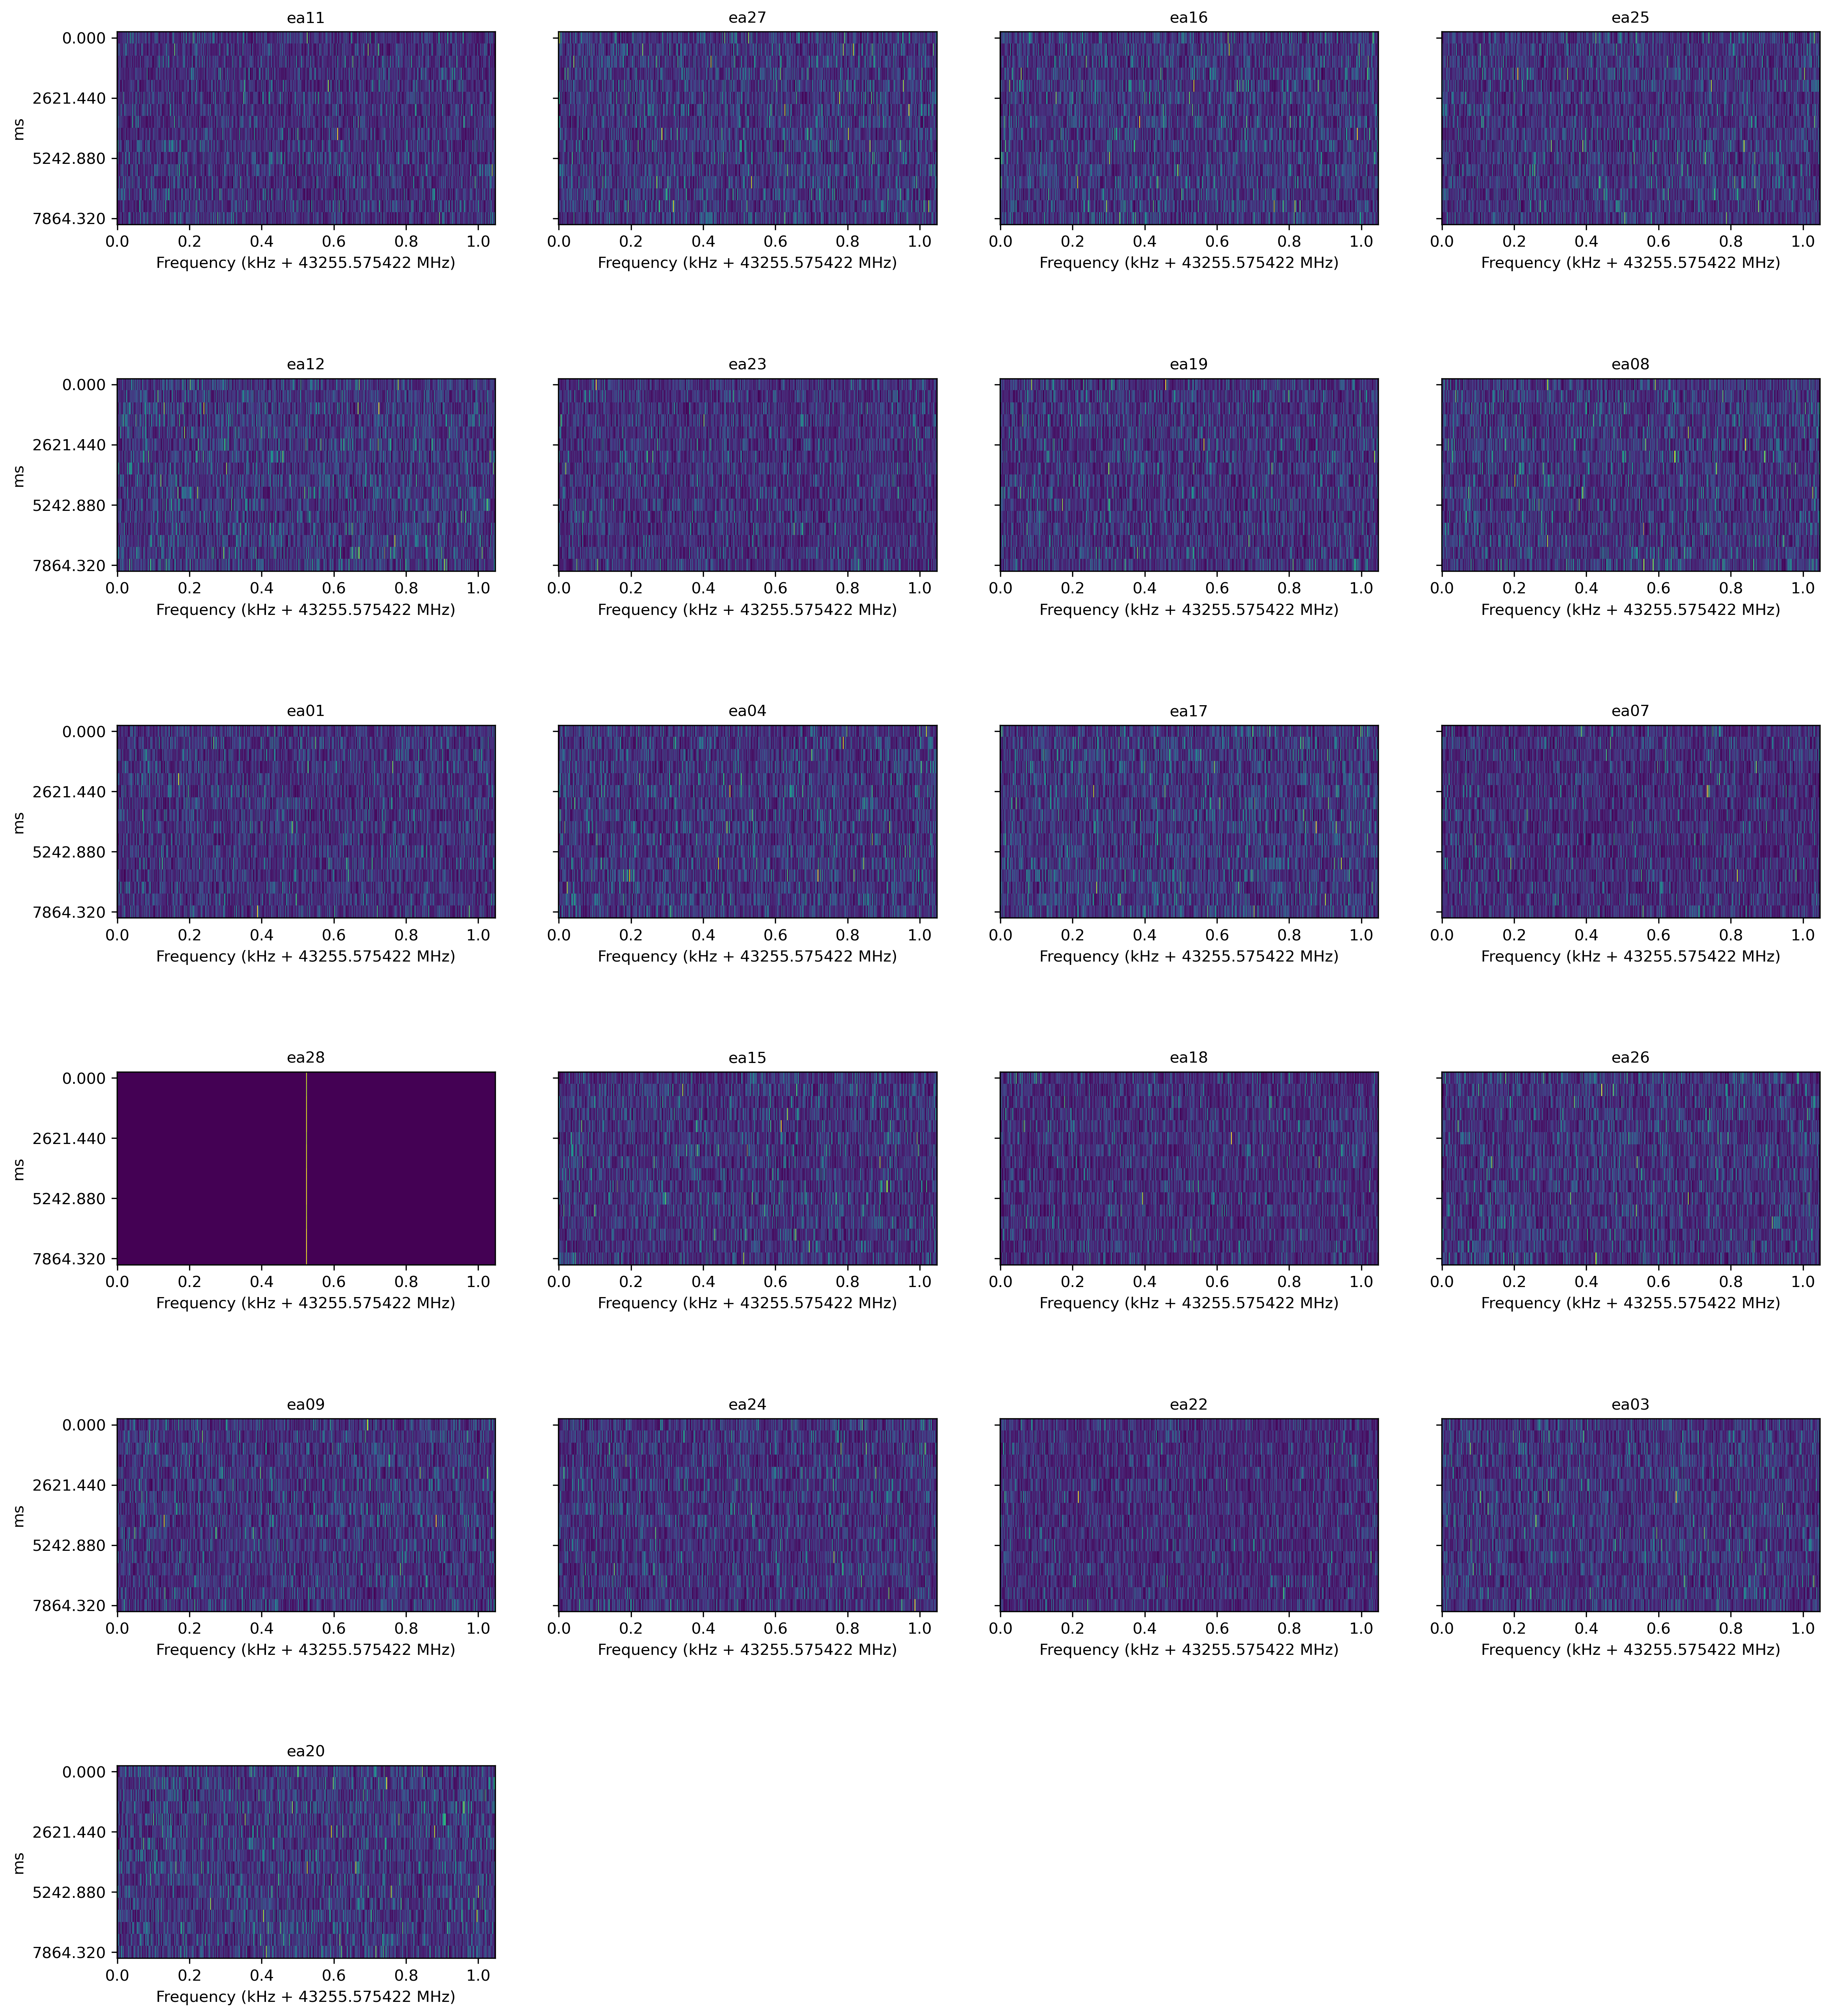

recalculated power: 1.077192e+14
local SNR: 13837.185084537112


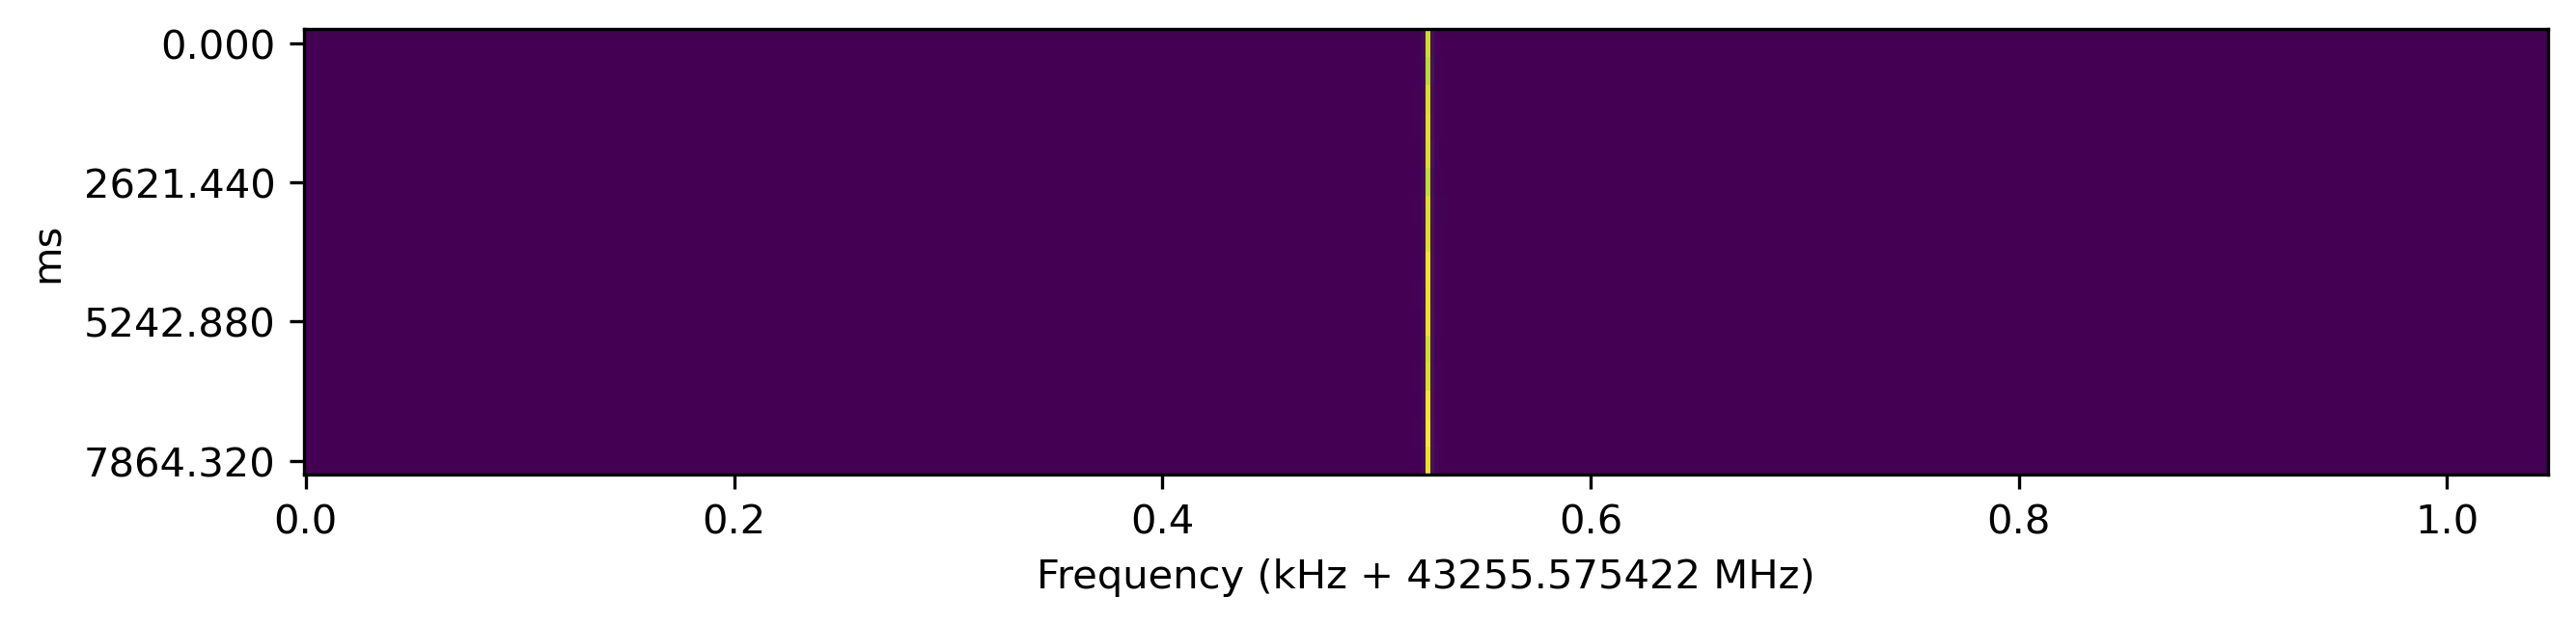

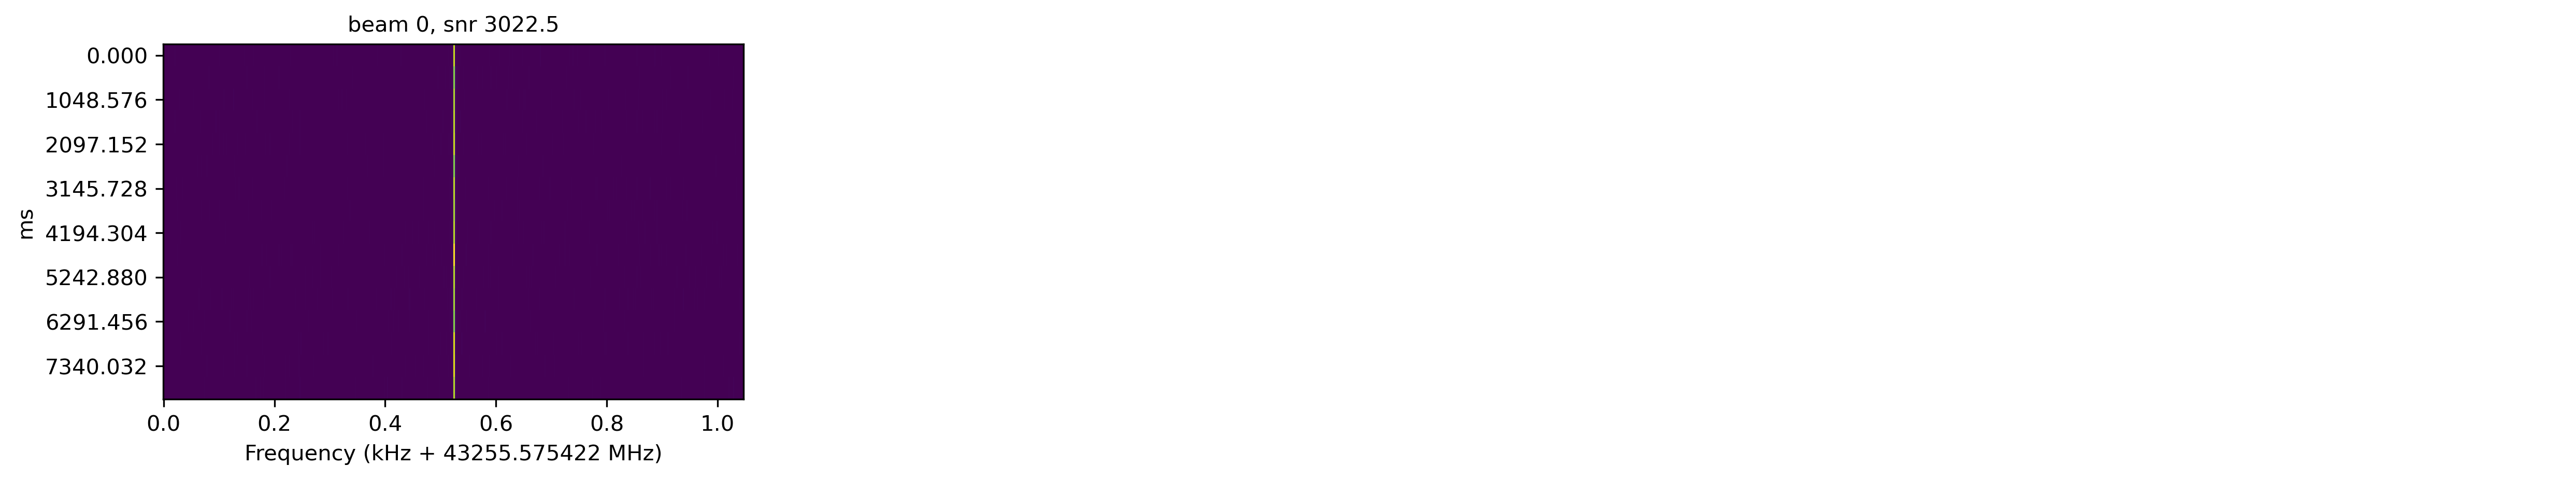

In [7]:
# Look at the stamp, note how a single antenna is at a way higher power, causing the signal
def look_at_stamp(stamp, title=None, show_signal=False):
    stamp.show_antennas(title=title, show_signal=show_signal)
    stamp.show_classic_incoherent(title=title, show_signal=show_signal)
    stamp.show_beams(title=title, show_signal=show_signal)

look_at_stamp(stamp)

In [8]:
# Figure out what's in this real array
stamp.real_array().shape
# 16 timesteps (index 0)
# 524 channels? (index 1)
# 2 polariations? (index 2)
# 21 antennas (index 3)
# 2 components of a complex number, 0 is I, 1 is Q

(16, 524, 2, 21, 2)

In [9]:
# So get the actual antenna incoherent power (power squared)
# by taking something like P^2 ~= (right circular polarization)^2 + (left circular polarization)^2
# and also that P^2 ~= (real component)^2 + (imaginary component)^2
# because we have a complex number (real and imaginary component) to describe what's received by each polarization?
antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4))
print(antenna_powers.shape)

(16, 524, 21)


In [10]:
# So now we want to look at the statistics for each antenna and also then the 
# antenna array to see if we can find an obvious outlier
medians = np.median(antenna_powers, axis=(0, 1))
maxes = np.max(antenna_powers, axis=(0, 1))
mins = np.min(antenna_powers, axis=(0, 1))
means = np.mean(antenna_powers, axis=(0, 1))

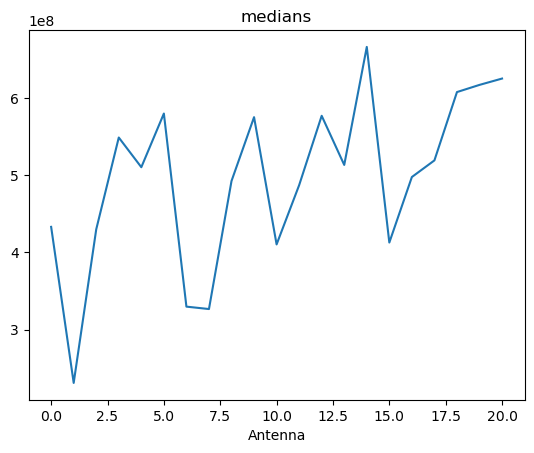

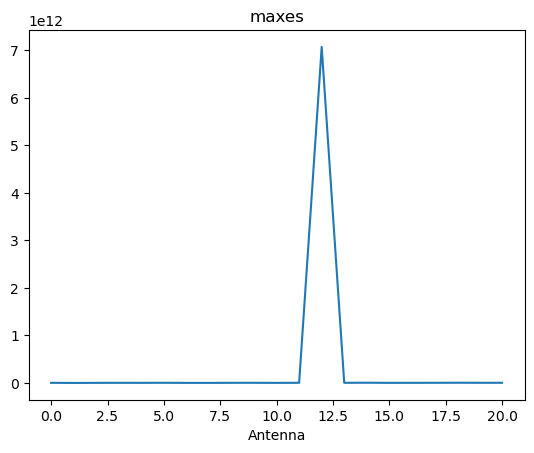

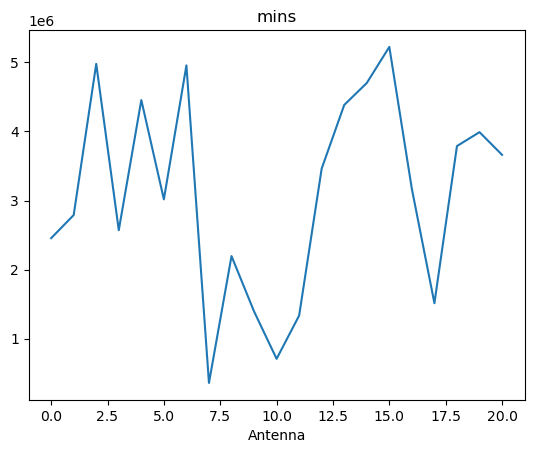

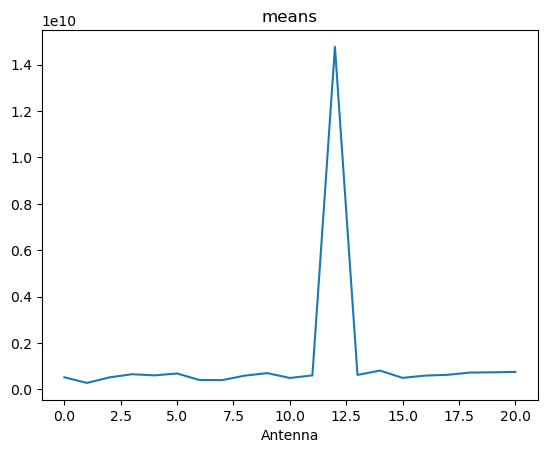

In [11]:
for stat, name in [(medians, "medians"), (maxes, "maxes"), (mins, "mins"), (means, "means")]:
    plt.plot(range(len(stat)), stat)
    plt.title(name)
    plt.xlabel("Antenna")
    plt.show()

No handles with labels found to put in legend.


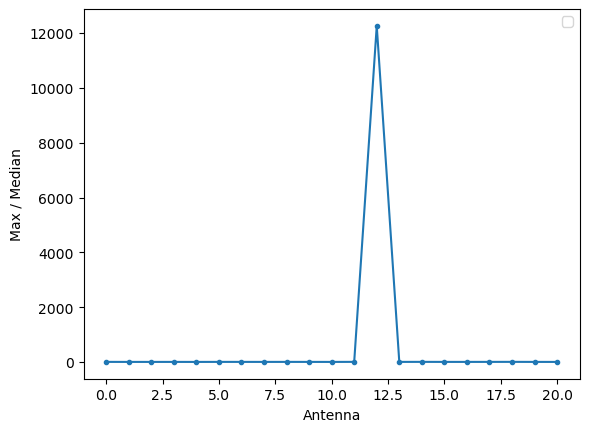

In [12]:
plt.plot(range(21), maxes / medians, marker='.')
antenna_signal_threshold = 100
plt.ylabel("Max / Median")
plt.xlabel("Antenna")
plt.legend()
plt.show()

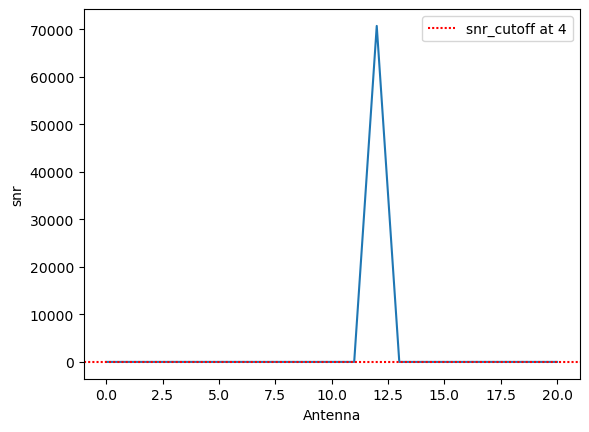

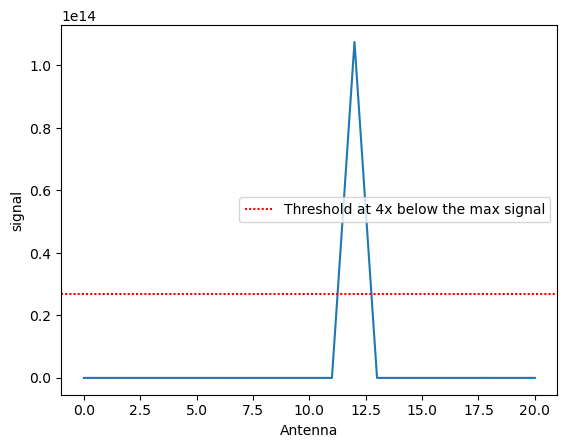

In [13]:
rearranged_antenna_powers = antenna_powers.transpose(2, 0, 1)
snr_and_signals = pd.DataFrame(np.array([stamp.snr_and_signal(antenna_power) for antenna_power in rearranged_antenna_powers]), 
                                   columns=["snr", "signal"])

plt.plot(range(len(snr_and_signals)), snr_and_signals["snr"])
snr_cutoff = 4
plt.axhline(snr_cutoff, label=f"snr_cutoff at {snr_cutoff}", dashes=[1, 1, 1, 1], c='r')
plt.xlabel("Antenna")
plt.ylabel("snr")
plt.legend()
plt.show()

plt.plot(range(len(snr_and_signals)), snr_and_signals["signal"])
antenna_signal_threshold=4
plt.axhline(max(snr_and_signals["signal"]) / antenna_signal_threshold, c='r', dashes=[1, 1, 1, 1], label=f"Threshold at {antenna_signal_threshold}x below the max signal")
plt.xlabel("Antenna")
plt.legend()
plt.ylabel("signal")
plt.show()

Text(0, 0.5, 'Count of Antennas with Strength')

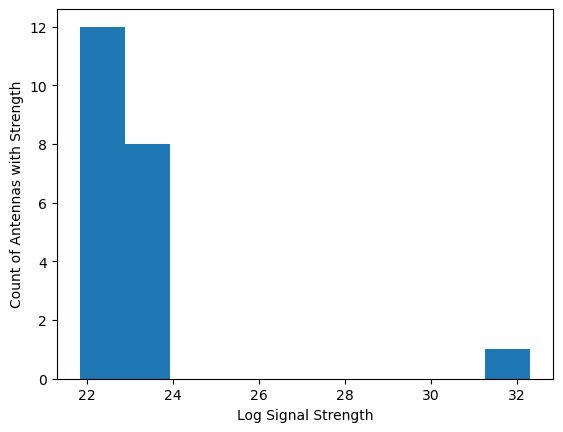

In [14]:
plt.hist(np.log(snr_and_signals["signal"]))
plt.xlabel("Log Signal Strength")
plt.ylabel("Count of Antennas with Strength")

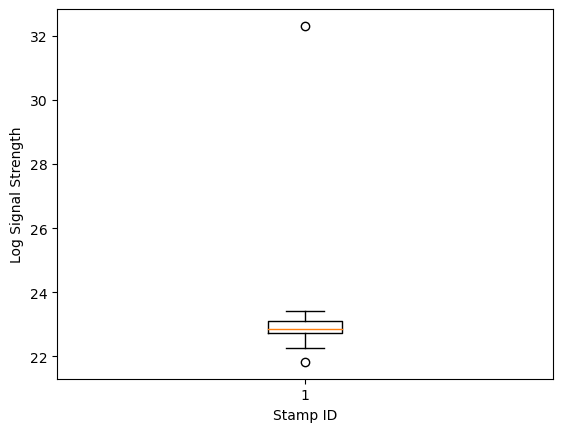

In [15]:
plt.boxplot(np.log(snr_and_signals["signal"]))
plt.xlabel("Stamp ID")
plt.ylabel("Log Signal Strength")
plt.show()

### 1st Pass Algorithm to find Outlier Antennas

In [16]:
# Given a stamp file, will check if there's a single
# antenna which is creating most of the signal observed
# Parameters:
# stamp - the stamp object
# snr - the signal to noise ratio above which there's deemed a signal
#       in the antenna. If None, doesn't check for this
# threshold - If a signal in a single antenna (or n_anomalous_antennas) is this much higher
#             than the signals in all other antennas, it's deemed anomalous
#             For example, if the powers of five anennas are [1, 4, 7, 10_000, 15]
#             then antenna 3 would be anomalous for a threshold of 10_000/15 (666.66...) or lower
# n_anomalous_antennas - The maximum number of antennas to look for interference in. Should be somewhere
#             between 1 (corresponding to looking for RFI in just one antenna, if there's RFI above the 
#             threshold in 2 antennas it won't count) and (the total number of antennas used - 1) 
#             which would be looking for RFI in all but one of the antennas (only if there's a signal above
#             the threshold in all antennas will the signal be deemed non-RFI)
# Returns:
# (indices_of_anomalous_antennas, threshold_of_detection) 
# indices_of_anomalous_antennas - a list of the anomalous antennas or an empty list if no
# anomalous signals are detected
# threshold_of_detection - The ratio between the maximum signal detected and the maximum signal 
#                          below the threshold or None if there are no signals above the snr cutoff in any antenna
def find_anomalous_antennas1(stamp, threshold, snr=None, n_anomalous_antennas=1):
    assert(threshold >= 1) # Threshold only makes sense if it's 1 or greater
    assert(stamp != None)
    assert(snr == None or isinstance(snr, (int, float))) # snr should be None or an int or a float
    
    # Get the powers in the frequency bins of each antenna by summing 
    # over polarization and complex magnitude
    # Also rearrange so indices are (antenna, time bin, frequency bin)
    antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4)).transpose(2, 0, 1)
    n_antennas = len(antenna_powers)
    assert(n_anomalous_antennas >= 1 and n_anomalous_antennas < n_antennas) # Look for [1, n_antennas - 1] anomalous antennas

    # Find the power and snr of each antenna
    snr_and_signals = pd.DataFrame(np.array([stamp.snr_and_signal(antenna_power) for antenna_power in antenna_powers]), 
                                   columns=["snr", "signal"])
    
    # Check the snr constraint if there is one
    if (snr != None):
        candidates_for_max = snr_and_signals["snr"] >= snr
        # Check if there's nothing we'd call a signal
        if candidates_for_max.sum() < 1:
            return ([], None) # No signals in any antenna
        index_of_max = snr_and_signals[candidates_for_max]["signal"].idxmax()
    else:
        index_of_max = snr_and_signals["signal"].idxmax()
    
    # Check how many signals are threshold times larger than the maximum
    maximum = snr_and_signals["signal"][index_of_max]
    indices_above_threshold = np.where(snr_and_signals["signal"] * threshold > maximum)[0]
    number_above_threshold = len(indices_above_threshold) # At least 1 because maximum * threshold > maximum (threshold >= 1)

    # Get the threshold of detection if we can
    if number_above_threshold < n_antennas:
        max_under_threshold = max(snr_and_signals["signal"][snr_and_signals["signal"] * threshold <= maximum])
        threshold_of_detection = maximum / max_under_threshold
    else:
        threshold_of_detection = None

    # If we see anomalies in the number of anomalous antennas we're looking for or fewer
    # (ie looking for 3 or fewer anomalous antennas and we see anomalously high signals
    # in two antennas) then deem it anomalous RFI, otherwise it's a normal signal which
    # was detected in multiple antennas
    if number_above_threshold <= n_anomalous_antennas:
        return (indices_above_threshold, threshold_of_detection)
    else:
        return ([], threshold_of_detection)

find_anomalous_antennas1(stamps[0], 100, snr=999)

(array([12]), 7293.226621695599)

In [17]:
# Try the function on the stamp file with a reasonable and super high threshold
# to see if it correctly finds the anomalous antenna or no signals which match the pattern
print(find_anomalous_antennas1(stamps[0], 100, snr=999))
print(find_anomalous_antennas1(stamps[0], 100000000, snr=999))

(array([12]), 7293.226621695599)
([], None)


In [18]:
# Look for anomalous anennas in all the stamps in the stamp file
threshold = 20
anomalies = [] # push (stamp, antennas, threshold) for anomalies
for i, stamp in enumerate(stamps):
    indices_of_anomalous_antennas, threshold_of_detection = find_anomalous_antennas1(stamp, threshold, snr=8, n_anomalous_antennas=7)
    if len(indices_of_anomalous_antennas) > 0:
        print(f"Stamps {i} has single-antenna RFI on antenna(s) {indices_of_anomalous_antennas} with a threshold of {threshold_of_detection} above signals in other antennas")
        anomalies.append((i, indices_of_anomalous_antennas, threshold_of_detection))

anomalies = np.array(anomalies, dtype='object')
print(len(anomalies), "anomalies")

Stamps 0 has single-antenna RFI on antenna(s) [12] with a threshold of 7293.226621695599 above signals in other antennas
Stamps 1 has single-antenna RFI on antenna(s) [20] with a threshold of 788.8552040978744 above signals in other antennas
Stamps 2 has single-antenna RFI on antenna(s) [13] with a threshold of 847.9269436269949 above signals in other antennas
Stamps 3 has single-antenna RFI on antenna(s) [11] with a threshold of 632.6049670049789 above signals in other antennas
Stamps 4 has single-antenna RFI on antenna(s) [15] with a threshold of 384.5748005454857 above signals in other antennas
Stamps 5 has single-antenna RFI on antenna(s) [7] with a threshold of 908.3348140558894 above signals in other antennas
Stamps 6 has single-antenna RFI on antenna(s) [10] with a threshold of 535.7480931283478 above signals in other antennas
Stamps 7 has single-antenna RFI on antenna(s) [5] with a threshold of 432.04595683360475 above signals in other antennas
Stamps 8 has single-antenna RFI o

In [19]:
stamps_with_anomalies = anomalies[:, 0]
anomalous_antennas = anomalies[:, 1]
anomalous_thresholds = anomalies[:, 2]

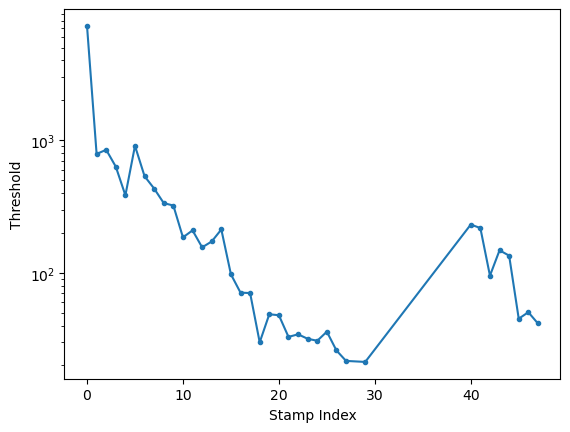

In [20]:
plt.plot(stamps_with_anomalies, anomalous_thresholds, marker='.')
plt.xlabel("Stamp Index")
plt.ylabel("Threshold")
plt.yscale('log')
plt.show()

In [21]:
# plt.plot(stamps_with_anomalies, anomalous_antennas, marker='.')
# plt.xlabel("Stamp Index")
# plt.ylabel("Antenna Index")
# plt.yscale('log')
# plt.show()

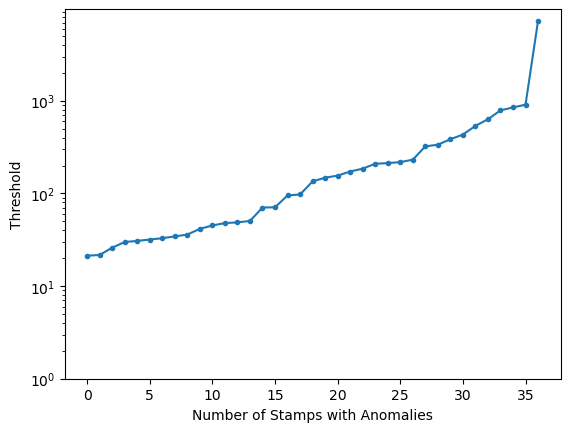

In [22]:
plt.plot(np.sort(anomalous_thresholds.copy()), marker='.')
plt.xlabel("Number of Stamps with Anomalies")
plt.ylabel("Threshold")
plt.yscale("log")
plt.ylim(bottom=1)
plt.show()

In [23]:
# unique_antennas, antenna_counts = np.unique(anomalous_antennas, return_counts=True)
# plt.bar(unique_antennas, antenna_counts)
# plt.xlabel("Antenna ID")
# plt.ylabel("Number of hits on that antenna")

In [24]:
# plt.scatter(anomalous_antennas, anomalous_thresholds, marker='.')
# plt.ylabel("Threshold of Detection")
# plt.xlabel("Antenna Index")
# plt.yscale('log')
# plt.show()

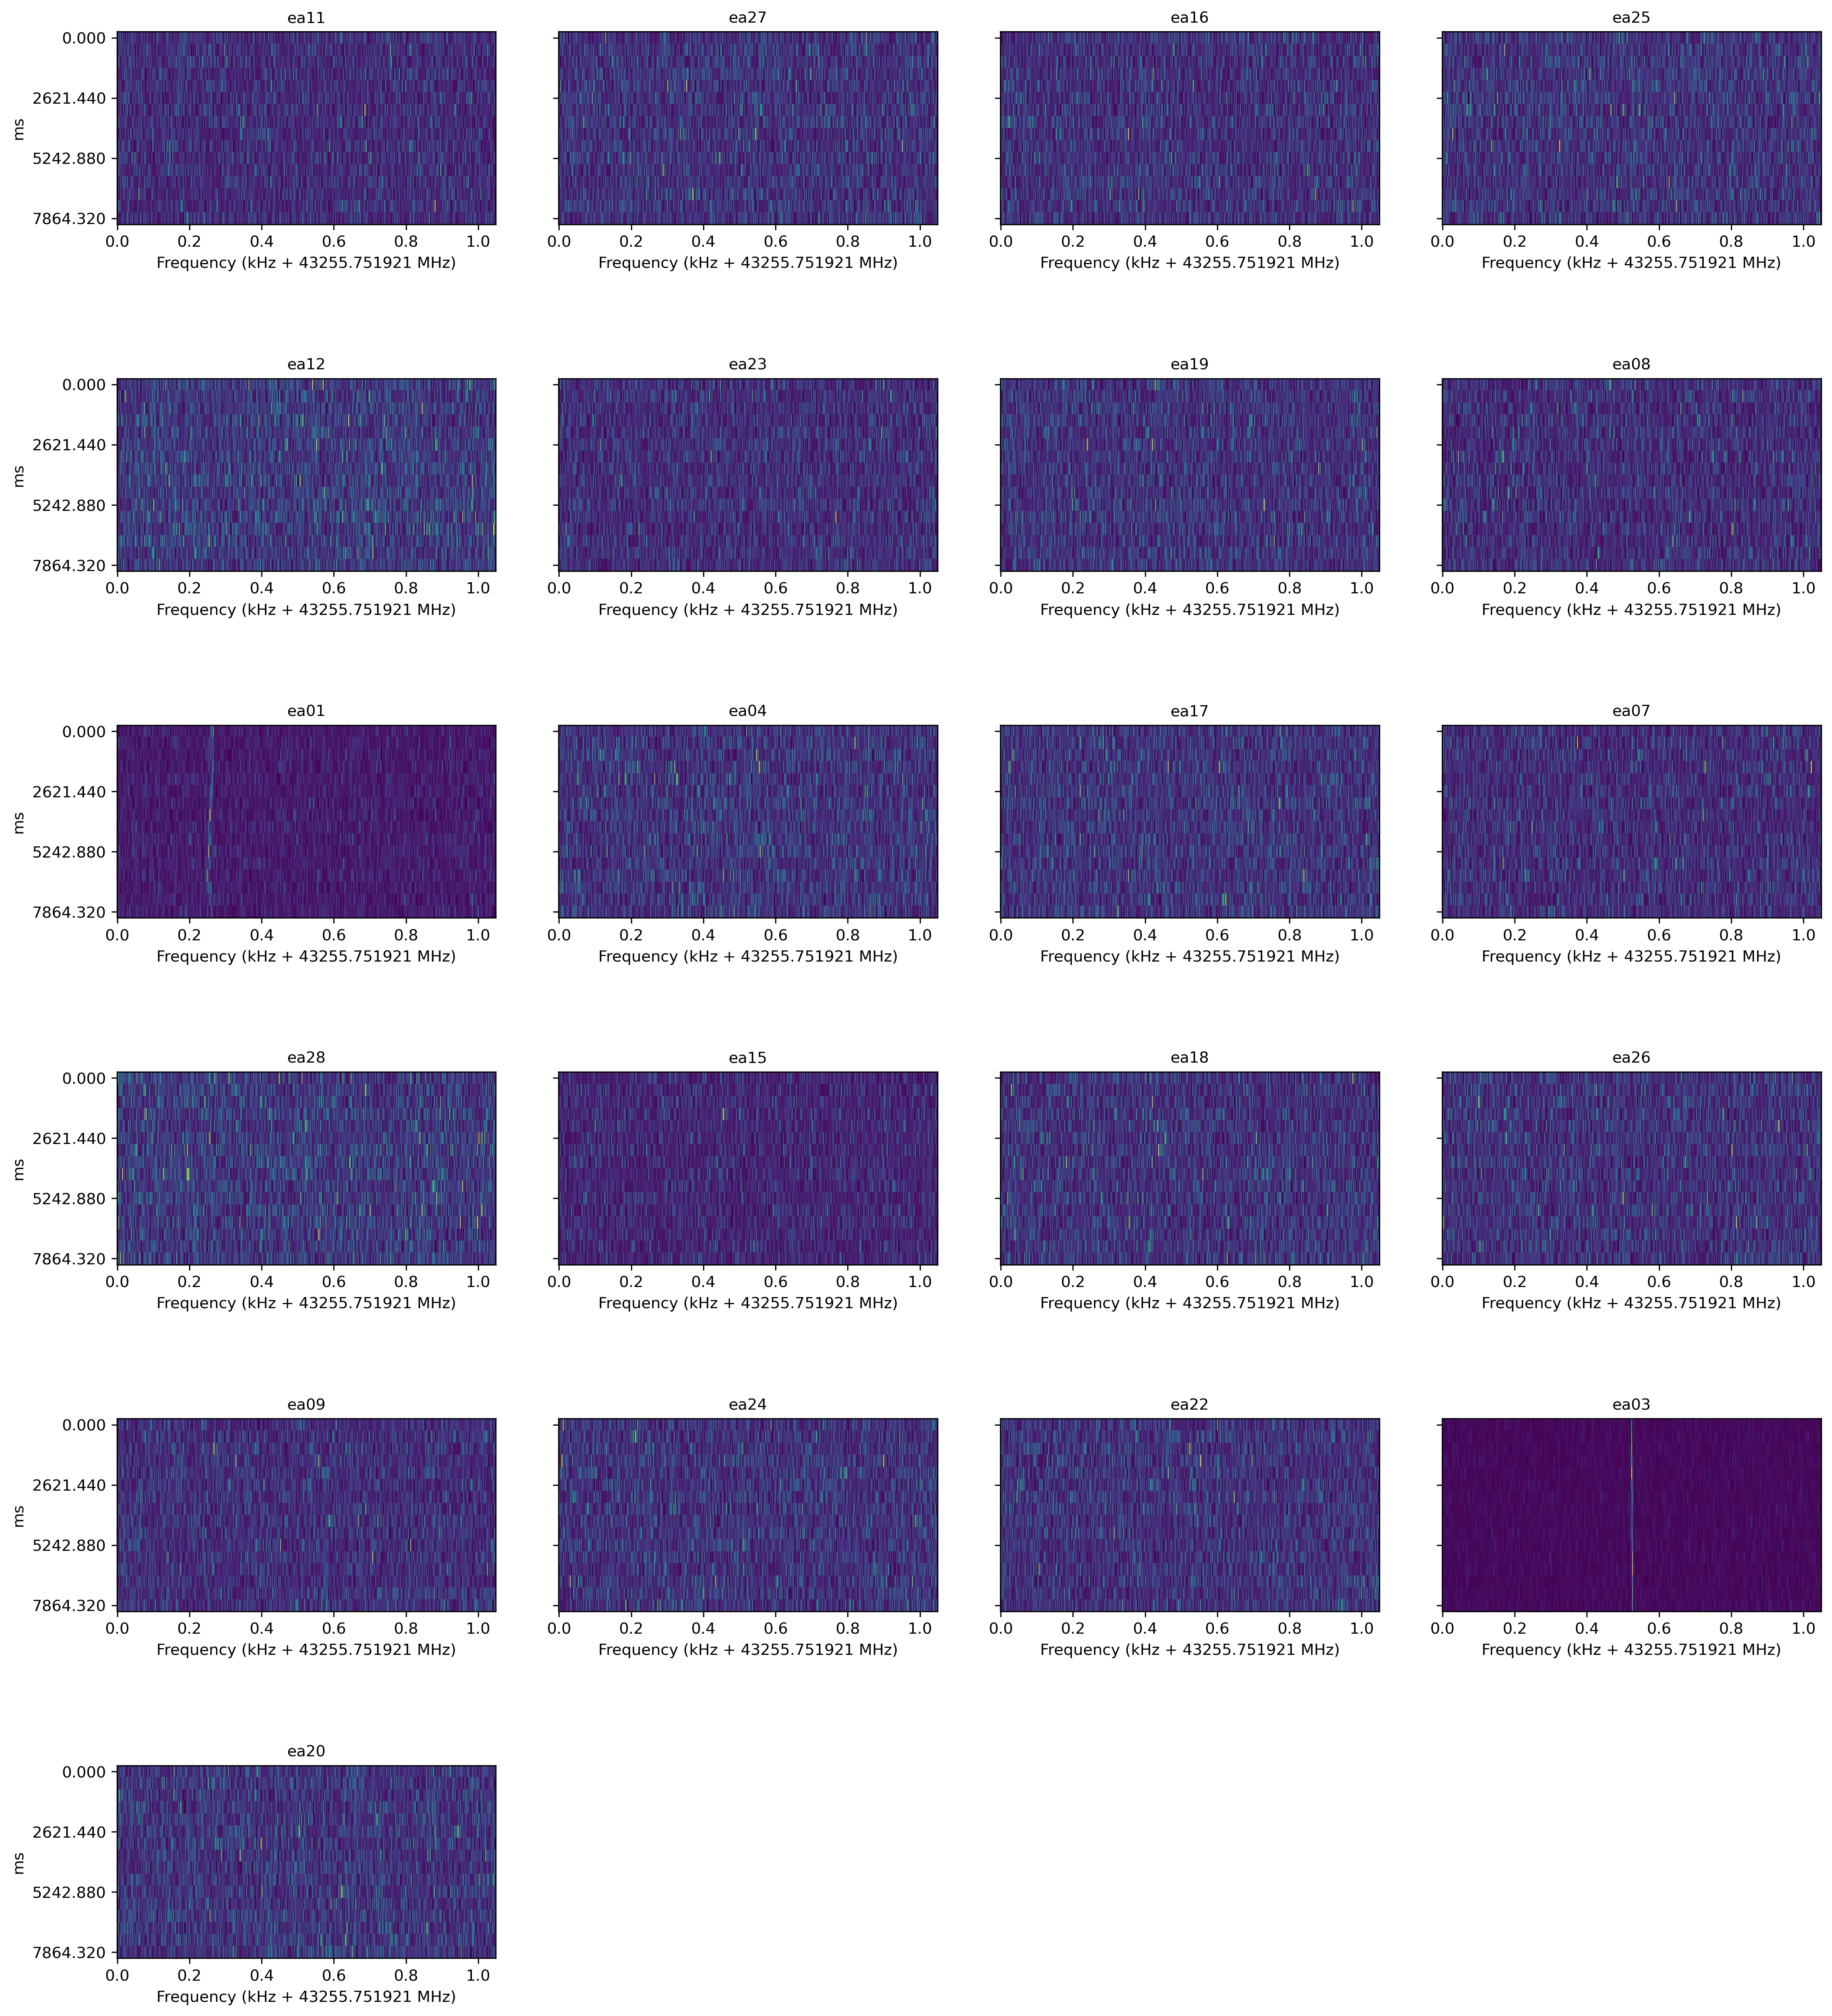

recalculated power: 5.651392e+11
local SNR: 23.40087066484517


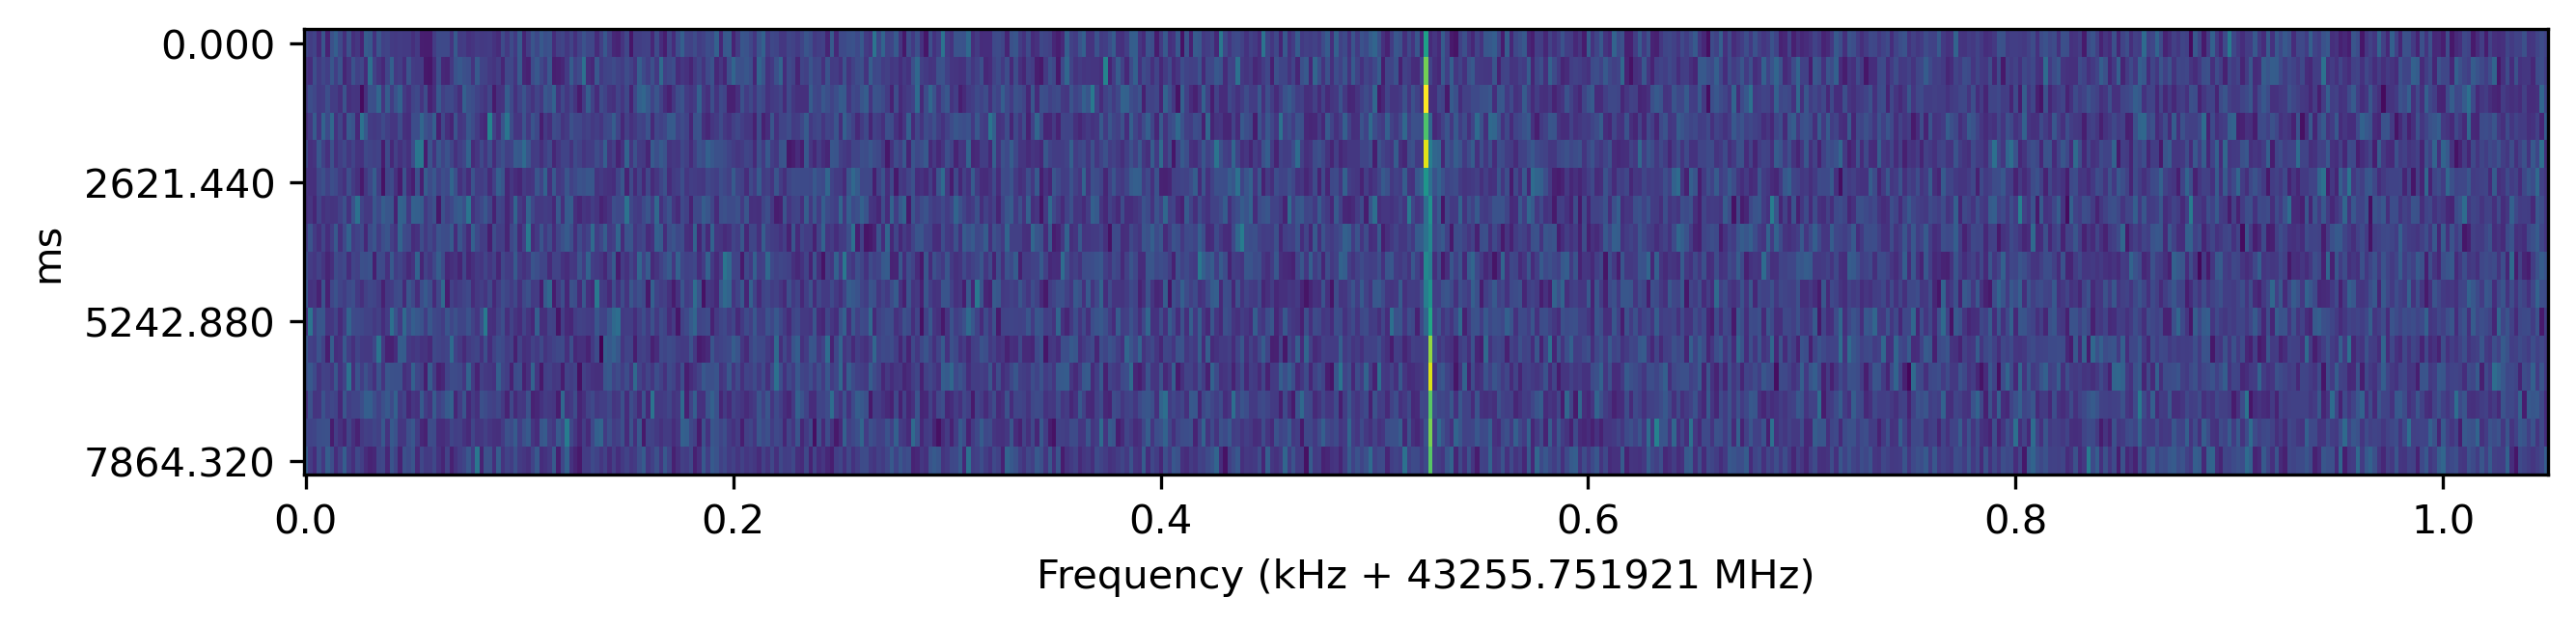

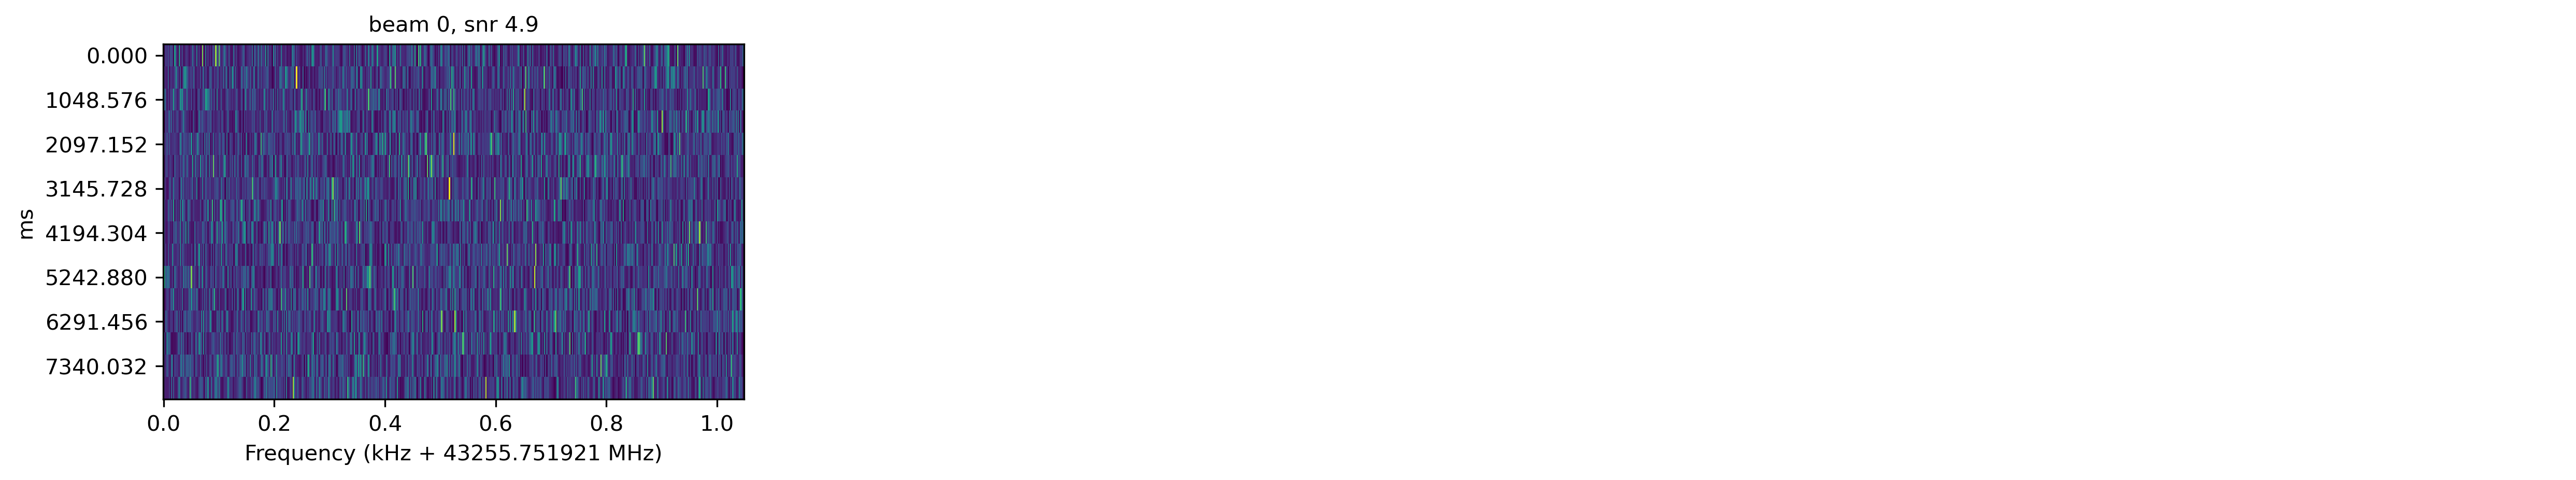

In [25]:
look_at_stamp(stamps[29], show_signal=False)

### 2nd Pass Algorithm

In [26]:
def find_anomalous_antennas2(stamp, std_dev_threshold=2.5, n_anomalous_antennas=1):
    assert(stamp != None)
    
    # Get the powers in the frequency bins of each antenna by summing 
    # over polarization and complex magnitude
    # Also rearrange so indices are (antenna, time bin, frequency bin)
    antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4)).transpose(2, 0, 1)
    n_antennas = len(antenna_powers)
    assert(n_anomalous_antennas >= 1 and n_anomalous_antennas < n_antennas) # Look for [1, n_antennas - 1] anomalous antennas

    # Find the power and snr of each antenna
    snr_and_signals = pd.DataFrame(np.array([stamp.snr_and_signal(antenna_power) for antenna_power in antenna_powers]), 
                                   columns=["snr", "signal"])
    
    # Figure out which antennas are more than the std dev threshold away from the mean
    signals = snr_and_signals["signal"]
    anomalous_antenna_indices = np.where((signals - signals.mean()).abs() > 
                                        (std_dev_threshold * signals.std()))[0]
    
    return anomalous_antenna_indices

# Test approach
print("Number of std deviations from mean, antennas outside that range")
for sigma in range(6):
    print(round(sigma, 2), find_anomalous_antennas2(stamps[0], sigma))

Number of std deviations from mean, antennas outside that range
0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
1 [12]
2 [12]
3 [12]
4 [12]
5 []


In [27]:
# Look for anomalous anennas in all the stamps in the stamp file
threshold = 2.5
anomalies = [] # push (stamp, std dev, antennas) for anomalies
for i, stamp in enumerate(stamps):
    anomalous_antenna_indices = find_anomalous_antennas2(stamp, std_dev_threshold=threshold, n_anomalous_antennas=7)
    if len(anomalous_antenna_indices) > 0:
        print(f"Stamps {i} has single-antenna RFI on antenna(s) {anomalous_antenna_indices}")
        anomalies.append((i, threshold, anomalous_antenna_indices))

anomalies = np.array(anomalies, dtype='object')
print(len(anomalies), "anomalies")

Stamps 0 has single-antenna RFI on antenna(s) [12]
Stamps 1 has single-antenna RFI on antenna(s) [20]
Stamps 2 has single-antenna RFI on antenna(s) [13]
Stamps 3 has single-antenna RFI on antenna(s) [11]
Stamps 4 has single-antenna RFI on antenna(s) [15]
Stamps 5 has single-antenna RFI on antenna(s) [7]
Stamps 6 has single-antenna RFI on antenna(s) [10]
Stamps 7 has single-antenna RFI on antenna(s) [5]
Stamps 8 has single-antenna RFI on antenna(s) [9]
Stamps 9 has single-antenna RFI on antenna(s) [8]
Stamps 10 has single-antenna RFI on antenna(s) [16]
Stamps 11 has single-antenna RFI on antenna(s) [15]
Stamps 12 has single-antenna RFI on antenna(s) [20]
Stamps 13 has single-antenna RFI on antenna(s) [14]
Stamps 14 has single-antenna RFI on antenna(s) [6]
Stamps 15 has single-antenna RFI on antenna(s) [17]
Stamps 16 has single-antenna RFI on antenna(s) [17]
Stamps 17 has single-antenna RFI on antenna(s) [9]
Stamps 18 has single-antenna RFI on antenna(s) [19]
Stamps 19 has single-antenna

### Look by eye at which ones should be single antenna RFI

In [28]:
# test_path = "/home/nstieg/test.png"
# stamps[0].show_antennas(title="stamps0", show_signal=True, save_to=test_path)

In [29]:
# for i, stamp in enumerate(stamps):
#     path = "/home/nstieg/BL-COSMIC-2024-proj/stamps/antenna_plots/"
#     filename = f"antennas_from_stamp{i}.png"
#     stamp.show_antennas(title=f"Stamp {i}", save_to=path+filename)

In [30]:
# for i in range(21):
#     stamp = stamps[1]
#     antenna_names = stamp.recipe.antenna_names
#     stamp.show_antenna(i, title=f"antenna {antenna_names[i]}")

In [31]:
# Run visual script (from ChatGPT)

stamp_indices_with_single_antennas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 40, 41, 42, 43, 44, 45, 46, 47]
antenna_indices_within_stamp = [12, 20, 13, 11, 15, 7, 10, 5, 9, 8, 16, 15, 20, 14, 6, 17, 17, 9, 19, 13, 10, 18, 17, 2, 16, 12, 18, 18, 19, 3, 5, 2, 6, 4, 0, 2, 2]

# Look at all those antennas to see if they're genuinely the ones with interference or if I have a typo
# for i in range(len(stamp_indices_with_single_antennas)):
#     stamp = stamps[stamp_indices_with_single_antennas[i]]
#     stamp.show_antenna(antenna_indices_within_stamp[i])

### Compare algorithms & GT

In [32]:
# So we have the "ground truth" of which antennas are faulty in which stamps
# Let's see how the scripts do
stamp_indices_with_single_antennas = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 40, 41, 42, 43, 44, 45, 46, 47]
antenna_indices_within_stamp = [12, 20, 13, 11, 15, 7, 10, 5, 9, 8, 16, 15, 20, 14, 6, 17, 17, 9, 19, 13, 10, 18, 17, 2, 16, 12, 18, 18, 19, 3, 5, 2, 6, 4, 0, 2, 2]

In [33]:

# Compare method 1 to the ground truth
def test_method_1(threshold, snr=None):
    for i, stamp in enumerate(stamps):
        indices_of_antennas, threshold_of_detection = find_anomalous_antennas1(stamp, threshold, snr)
        if len(indices_of_antennas) == 0:
            assert(i not in stamp_indices_with_single_antennas)
        else:
            true_antenna_index = antenna_indices_within_stamp[stamp_indices_with_single_antennas.index(i)]
            assert(indices_of_antennas[0] == true_antenna_index)

test_method_1(10)

In [34]:
def test_method_2(std_dev_threshold):
    for i, stamp in enumerate(stamps):
        indices_of_antennas = find_anomalous_antennas2(stamp, std_dev_threshold=std_dev_threshold)
        if len(indices_of_antennas) == 0:
            assert(i not in stamp_indices_with_single_antennas)
        else:
            true_antenna_index = antenna_indices_within_stamp[stamp_indices_with_single_antennas.index(i)]
            assert(indices_of_antennas[0] == true_antenna_index)

test_method_2(3)

In [35]:
xaxis_1 = np.linspace(1.0001, 30, 100)
yaxis_1 = []
for threshold in xaxis_1:
    try:
        test_method_1(threshold)
        yaxis_1.append(True)
    except:
        yaxis_1.append(False)

print(yaxis_1)

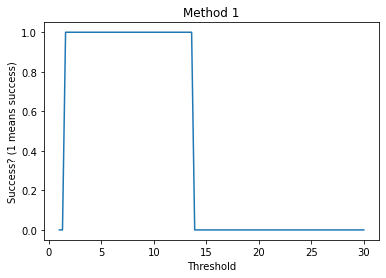

In [ ]:
plt.plot(xaxis_1, yaxis_1)
plt.xlabel("Threshold")
plt.ylabel("Success? (1 means success)")
plt.title("Method 1")
plt.show()

In [ ]:
xaxis_1 = np.linspace(1.0001, 30, 25) # Threshold
yaxis_1 = np.linspace(1.0001, 30, 25) # SNR
zaxis_1 = np.full((100, 100), None)
for i, threshold in enumerate(xaxis_1):
    for j, snr_threshold in enumerate(yaxis_1):
        try:
            test_method_1(threshold)
            zaxis_1[i, j] = True
        except:
            zaxis_1[i, j] = False

In [ ]:
zaxis_1 = np.array(zaxis_1, dtype=bool)[0:25, 0:25]

In [ ]:
xaxis_spacings

array([ 0.  ,  6.25, 12.5 , 18.75, 25.  ])

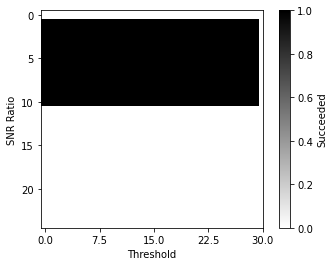

In [ ]:
plt.imshow(zaxis_1, cmap="binary")
plt.xlabel("Threshold")
plt.ylabel("SNR Ratio")
xaxis_spacings = np.linspace(0, len(xaxis_1), 5)
yaxis_spacings = np.linspace(0, len(yaxis_1), 5)
plt.xticks(xaxis_spacings, xaxis_spacings * (30 / len(xaxis_1)))
plt.xticks(yaxis_spacings, yaxis_spacings * (30 / len(yaxis_1)))
cbar = plt.colorbar(label="Succeeded")
plt.show()

In [ ]:
xaxis_2 = np.linspace(0, 10, 100)
yaxis_2 = []
for sigma in xaxis_2:
    try:
        test_method_2(sigma)
        yaxis_2.append(True)
    except:
        yaxis_2.append(False)

print(yaxis_2)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


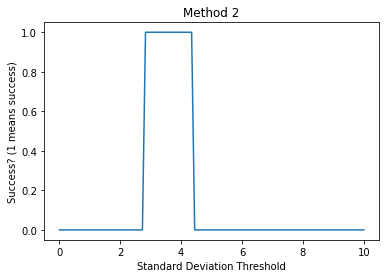

In [ ]:
plt.plot(xaxis_2, yaxis_2)
plt.xlabel("Standard Deviation Threshold")
plt.ylabel("Success? (1 means success)")
plt.title("Method 2")
plt.show()

Figure out what antenna actually corresponded with the ids of the antennas

In [46]:
# Print antenna names for each SARFI found
for index in range(len(stamp_indices_with_single_antennas)):
    # Get stamp
    stamp_index = stamp_indices_with_single_antennas[index]
    antenna_index = antenna_indices_within_stamp[index]
    stamp = stamps[stamp_index]
    assert(stamp.recipe is not None)

    # Get the name of the bad antenna
    antenna_titles = [stamp.recipe.antenna_names[i] for i in range(stamp.stamp.numAntennas)]
    # antenna_nums = [int(title[2:]) for title in antenna_titles]
    antenna_title_of_SARFI = antenna_titles[antenna_index]

    # Print info
    print(f"Stamp {stamp_index} had SARFI on {antenna_title_of_SARFI} at {stamp.stamp.signal.frequency}MHz")

Stamp 0 had SARFI on ea28 at 43255.57592190021MHz
Stamp 1 had SARFI on ea20 at 43255.79166973346MHz
Stamp 2 had SARFI on ea15 at 43255.5983198952MHz
Stamp 3 had SARFI on ea07 at 43255.54647052997MHz
Stamp 4 had SARFI on ea26 at 43255.65711010211MHz
Stamp 5 had SARFI on ea08 at 43255.38747776263MHz
Stamp 6 had SARFI on ea17 at 43255.52046573871MHz
Stamp 7 had SARFI on ea23 at 43256.30264461749MHz
Stamp 8 had SARFI on ea04 at 43255.49670398944MHz
Stamp 9 had SARFI on ea01 at 43255.47007358783MHz
Stamp 10 had SARFI on ea09 at 43255.70028675311MHz
Stamp 11 had SARFI on ea26 at 43255.67547405475MHz
Stamp 12 had SARFI on ea20 at 43255.78209865802MHz
Stamp 13 had SARFI on ea18 at 43255.65147197955MHz
Stamp 14 had SARFI on ea19 at 43256.36075199359MHz
Stamp 15 had SARFI on ea24 at 43255.722200281554MHz
Stamp 16 had SARFI on ea24 at 43255.7106283974MHz
Stamp 17 had SARFI on ea04 at 43255.48649013751MHz
Stamp 18 had SARFI on ea03 at 43255.769145853454MHz
Stamp 19 had SARFI on ea15 at 43255.58765